# **Time-Dependent Vehicule Routing Problem (TDVRP) -- Ant Colony Optimization (ACO) + Geolocation**

## **PHASE OF THE CRISP-DM: BUSINESS UNDERSTANDING**

Time-Dependent Vehicule Routing Problem (TDVRP) -- Ant Colony Optimization (ACO) + Geolocation

O problema de roteamento de veículos (VRP) é um problema na área da otimização combinatória. Consiste no atendimento de um conjunto de consumidores por intermédio de uma frota de veículos, que partem de um ou mais pontos denominados depósitos. Além disso, possui a restrição de capacidade do veículo.

Nesse caso, o problema consiste no time-dependent VRP, ou seja, o tempo da rota deve ser minimizado.

Portanto, o problema consiste em encontrar as rotas ótimas, ou seja, a sequência ótima dos pontos de geolocalização (latitude e longitude) minimizando oo tempo da rota. Estes dados podem ser, por exemplo, pontos de parada de ônibus.

A rota inicia em um ponto definido e chega em outro ponto definido.

É necessário respeitar as restrições de tempo e capacidade de pessoas por ônibus.

Restrições:

1) Tempo total da rota: 120 min

2) Tempo de espera em cada parada: 1 min

3) Capacidade máxima de pessoas por ônibus: 60 pessoas

## **PHASE OF THE CRISP-DM: DATA UNDERSTANDING**

Nesta etapa foi realizada a análise exploratória da base. Foi verificado como o dataset é apresentado e suas dimensões.

In [ ]:
pip install osmnx

In [95]:
# Importação das bibliotecas
# Para os dados
import numpy as np
import pandas as pd
%matplotlib inline

# para grafo e análise geoespacial
import networkx as nx
import osmnx as ox
import folium

In [96]:
# Leitura dos dados do df de centroides (paradas de ônibus)
dt_centroides = pd.read_excel('dt_centroidesfiltro_100pontos.xlsx')
dt_centroides.head(5)

,Cluster,LatRadCentroid,LongRadCentroid,LatDegCentroid,LongDegCentroid,Pontos
0,0,-0.138769,-0.608093,-7.950867,-34.841142,8
1,1,-0.138352,-0.609447,-7.927014,-34.918721,26
2,6,-0.138496,-0.609711,-7.935250,-34.933892,15
3,7,-0.140728,-0.609362,-8.063111,-34.913874,5
4,8,-0.141614,-0.609557,-8.113870,-34.925056,11


Dados que serão utilizados do dataset: 

*LatDegCentroid* - latidude do ponto em graus

*LongDegCentroid* - longitude do ponto em graus

*Pontos* - quantidade de pessoas (peso)

In [97]:
# Verificação das dimensões do dataset
print("Apresentando a dimensão dos dados: {}".format(dt_centroides.shape))

Apresentando a dimensão dos dados: (103, 6)


## **PHASE OF THE CRISP-DM: DATA PREPARATION**

Nesta etapa foi realizada a preparação dos dados: 

1) foi gerado e plotado o grafo das estradas através de uma bounding box.

2) para cada ponto de geolocalização (coordenadas de latitude e longitude) foi encontrado o nó mais próximo no grafo.

3) foram calculadas as matrizes de distância e tempo.

In [99]:
# Download da rede de estradas a partir de uma bounding box 
# Esse processo leva bastante tempo, dependendo da bounding box 
try:
    G = ox.load_graphml('grafo.graphml')
    print('A informação do mapa foi lida e o grafo foi criado.')
except:
    G = ox.graph_from_bbox(-7.5552554,-8.346182733,-35.0333858,-34.8085112, network_type='drive') #bounding box --- north lat, south lat, east long, west long
    ox.save_graphml(G, filepath='grafo.graphml')
    print("Grafo salvo.")
    G = ox.load_graphml('grafo.graphml')
    print('A informação do mapa foi lida e o grafo foi criado.')

A informação do mapa foi lida e o grafo foi criado.


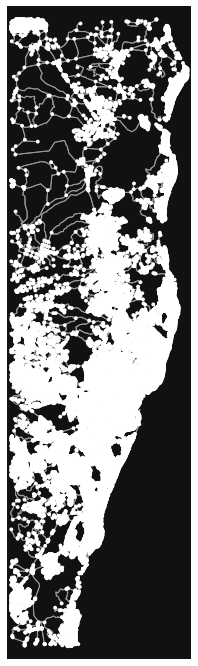

In [3]:
# Visualização do grafo
fig, ax = ox.plot_graph(G,figsize=(12, 12))

In [100]:
# Dados de latitude e longitude das paradas de ônibus
paradas_lat = dt_centroides['LatDegCentroid']
paradas_long = dt_centroides['LongDegCentroid']
print('Número de paradas: ' + str(len(paradas_lat)))

Número de paradas: 103


In [127]:
dt_centroides.iloc[52]

Cluster            102.000000
LatRadCentroid      -0.141402
LongRadCentroid     -0.609103
LatDegCentroid      -8.101765
LongDegCentroid    -34.899018
Pontos               7.000000
Name: 52, dtype: float64

In [128]:
dt_centroides.iloc[68]

Cluster            135.000000
LatRadCentroid      -0.137302
LongRadCentroid     -0.609217
LatDegCentroid      -7.866798
LongDegCentroid    -34.905562
Pontos               7.000000
Name: 68, dtype: float64

In [101]:
# Para cada ponto de latitude e longitude, encontra o nó mais próximo no grafo 
nearest_nodes = []
places = []
all_places = np.array(range(len(paradas_long)))
for place in all_places: 
    places.append(place) 
    nearest = ox.distance.nearest_nodes(G, X=paradas_long[place],Y=paradas_lat[place]) 
    nearest_node=G.nodes[nearest] 
    nearest_node['id'] = nearest  
    nearest_node['name'] = place
    nearest_nodes.append(nearest_node.copy()) 

# Imprime os nós
nearest_nodes 

[{'id': 5349622673,
  'name': 0,
  'street_count': 1,
  'x': -34.8440503,
  'y': -7.9543165},
 {'id': 7222905290,
  'name': 1,
  'street_count': 1,
  'x': -34.9196376,
  'y': -7.9262507},
 {'id': 2553665604,
  'name': 2,
  'street_count': 3,
  'x': -34.9340625,
  'y': -7.9353281},
 {'id': 3810785077,
  'name': 3,
  'street_count': 3,
  'x': -34.9140358,
  'y': -8.063186},
 {'id': 1641457476,
  'name': 4,
  'street_count': 4,
  'x': -34.9250776,
  'y': -8.1135745},
 {'id': 2305089435,
  'name': 5,
  'street_count': 1,
  'x': -34.8991684,
  'y': -7.9418469},
 {'id': 7656048736,
  'name': 6,
  'street_count': 3,
  'x': -34.9204785,
  'y': -7.9961617},
 {'id': 1817089441,
  'name': 7,
  'street_count': 3,
  'x': -34.8645638,
  'y': -7.9404711},
 {'id': 7245120393,
  'name': 8,
  'street_count': 3,
  'x': -34.8848453,
  'y': -7.9484551},
 {'id': 1446653196,
  'name': 9,
  'street_count': 3,
  'x': -34.9013122,
  'y': -8.1194207},
 {'id': 5378982751,
  'name': 10,
  'street_count': 1,
  'x':

In [102]:
# Calcula a matriz de distância entre todos os nós do grafo
# O processo leva bastante tempo, dependendo da quantidade de pontos
distance_matrix = []
for source_node in nearest_nodes:
    distance_row = []
    for target_node in nearest_nodes:        
        distance = 0;
        if source_node['id'] != target_node['id'] and nx.has_path(G,source_node['id'],target_node['id']): # retorna True se G tem um caminho da origem ao destino, caso contrário False
            distance = nx.shortest_path_length(G, source_node['id'],target_node['id'],weight='length', method='dijkstra') # calcula o comprimento do caminho mais curto

        elif source_node['id'] == target_node['id']: 
            distance = 0

        else:
            distance = np.inf

        distance_row.append(distance) 
    distance_matrix.append(distance_row) 
    
distance_matrix = np.array(distance_matrix) 

# Imprime a matriz de distância
distance_matrix

array([[    0.   , 12023.896, 14563.877, ...,  7488.42 , 19916.099,
         1987.289],
       [11722.999,     0.   ,  9206.297, ..., 14815.091, 14126.159,
        12759.414],
       [12214.911,  9684.809,     0.   , ..., 13653.497, 19190.633,
        13251.326],
       ...,
       [ 7800.078, 15002.101, 17012.842, ...,     0.   , 23205.925,
         6672.468],
       [19511.466, 13467.717, 18306.746, ..., 22681.448,     0.   ,
        20547.881],
       [ 1987.289, 13060.311, 15600.292, ...,  6603.479, 20952.514,
            0.   ]])

In [110]:
# Salvando a matriz de distância
matrizdistancia_100pontos = pd.DataFrame(distance_matrix)
matrizdistancia_100pontos.to_excel('matrizdistancia_100pontos.xlsx') 
matrizdistancia_100pontos.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102
0,0.000,12023.896,14563.877,17074.007,22596.582,7774.289,13311.771,3497.214,5995.892,23034.707,7067.178,20322.643,32668.381,21151.247,8553.242,10412.248,2970.942,10456.876,6106.731,15345.837,6402.111,6863.828,5756.317,4123.924,11610.106,4744.175,20294.294,15651.011,5227.737,14981.635,23604.899,6916.773,4592.992,8117.899,18631.603,16932.594,35203.948,14581.391,13429.160,19791.968,...,14165.961,10436.435,13799.675,6535.605,15569.953,14622.860,17655.701,4605.614,18414.729,19016.235,6659.460,6992.780,12012.717,15407.251,21989.020,33242.861,12827.121,13486.104,14927.411,7600.291,8476.115,8030.651,7449.265,3622.113,6431.735,12001.290,9992.645,11927.123,3363.862,15468.495,10550.636,14352.128,13284.617,14851.414,19595.151,18639.723,4263.491,7488.420,19916.099,1987.289
1,11722.999,0.000,9206.297,22430.654,26494.170,5638.339,14146.650,8865.606,7247.006,29097.899,13504.657,14532.703,26878.441,24136.692,6152.418,11861.309,11764.785,3551.868,13433.402,14111.188,11083.855,13301.307,12193.796,10935.626,14686.627,7440.742,14504.354,21706.974,12385.580,22415.291,26675.548,13354.252,8137.582,14555.378,18806.905,11142.654,29414.008,8791.451,18820.176,24594.154,...,8376.021,17980.091,14648.303,13315.128,9780.013,8832.920,18735.838,9188.638,22438.261,13226.295,14625.232,16385.834,18145.618,9617.311,16199.080,27452.921,1440.373,18842.751,20284.058,15143.947,16019.771,6379.796,6818.118,13377.022,12869.214,2999.485,7058.154,14612.845,12356.926,9678.555,16233.436,8562.188,3096.726,17800.485,22732.297,12849.783,11043.014,14815.091,14126.159,12759.414
2,12214.911,9684.809,0.000,20709.860,24773.376,5294.561,12425.856,9378.652,6465.398,27377.105,14017.703,19597.177,31942.915,22415.898,4431.624,10140.515,11661.081,9451.674,12565.086,12390.394,9511.205,13814.353,12706.842,11448.672,12965.833,8595.830,19568.828,19986.180,12898.626,20694.497,24954.754,13867.298,8710.323,15068.424,17086.111,16207.128,34478.482,13855.925,17099.382,22873.360,...,13440.495,16787.443,12927.509,12059.403,14844.487,13897.394,17015.044,8998.804,20717.467,18290.769,14521.528,16898.880,16424.824,14681.785,21263.554,32517.395,10488.034,17121.957,18563.264,14685.837,15018.165,4676.693,5245.468,13273.318,13382.260,9662.203,5337.360,12892.051,12253.222,14743.029,14512.642,13626.662,10945.530,16079.691,21011.503,17914.257,10939.310,13653.497,19190.633,13251.326
3,17492.223,21952.238,23437.619,0.000,6830.620,17288.865,9842.636,18357.332,16070.675,7641.310,22996.383,31864.606,44210.344,4084.191,16182.464,14078.766,14890.166,21719.103,11500.164,9278.136,14891.889,22793.033,21685.522,20236.676,8316.083,18756.664,31836.257,1931.789,21340.489,4949.519,7231.955,22421.949,17689.003,24047.104,6111.645,28474.557,46745.911,26123.354,4226.493,2724.912,...,25707.924,8427.060,8913.694,12407.242,27111.916,26164.823,5135.743,16863.678,1417.897,30558.198,11092.755,19864.822,5716.266,26949.214,33530.983,44784.824,22755.463,4618.391,3431.832,11370.084,9631.924,16767.074,15833.115,13975.262,22360.940,21929.632,17781.653,8894.010,14614.381,27010.458,6873.870,25894.091,23212.959,5637.575,3514.237,30181.686,13527.813,10480.014,31458.062,16271.881
4,22978.914,26768.308,28253.689,6796.520,0.000,22400.234,15727.705,24437.398,22405.062,3672.801,28666.621,36680.676,49026.414,2963.081,20998.534,20194.443,20882.333,26535.173,17834.551,13000.388,21226.276,28463.271,27355.760,25723.367,14650.470,24836.730,36652.327,8259.889,26827.180,8196.220,1696.002,27908.640,23769.069,29717.342,10390.238,33290.627,51561.981,30939.424,10333.500,4065.973,...,30523.994,14389.507,14802.582,18741.629,31927.986,30980.893,9995.275,22943.744,6228.217,35374.268,16579.446,25351.513,11823.273,31765.284,38347.053,49600.894,27571.533,10952.778,8882.757,17152.813,15645.559,21778.680,22167.502,19461.953,28031.178,267

In [111]:
# Convertendo a matriz de distância para matriz de tempo a partir da velocidade
# Definindo a velocidade como 40km/h
kmh_to_meterpermin = 667 #de km/h para m/min
time_matrix = distance_matrix/kmh_to_meterpermin

# Imprime a matriz de tempo
time_matrix

array([[ 0.        , 18.02683058, 21.83489805, ..., 11.22701649,
        29.85921889,  2.97944378],
       [17.57571064,  0.        , 13.80254423, ..., 22.21153073,
        21.17864918, 19.12955622],
       [18.3132099 , 14.51995352,  0.        , ..., 20.47001049,
        28.77156372, 19.86705547],
       ...,
       [11.69426987, 22.49190555, 25.50650975, ...,  0.        ,
        34.79149175, 10.00370015],
       [29.25257271, 20.19147976, 27.4463958 , ..., 34.00516942,
         0.        , 30.80641829],
       [ 2.97944378, 19.58067616, 23.38874363, ...,  9.90026837,
        31.41306447,  0.        ]])

## **PHASE OF THE CRISP-DM: MODELING**

Nesta etapa foi realizada a otimização geoespacial com o algoritmo ACO além da solução do problema VRP (Vehicle Routing Problem) levando em consideração o tempo total de rota e a capacidade máxima de pessoas no ônibus.


In [112]:
# Cria o ambiente e matriz de pheremon
def create_environment(time_matrix, stops, eps = 0.0001):
    '''
    Cria o ambiente e a matriz de pheremon
    '''
    N =len(stops)

    def pheremon_matrix(stops, eps = eps):
        N =len(stops)
        data = (np.ones((N,N))- np.eye(N)) / (N-1) 
        phe = pd.DataFrame(data=data, columns = stops, index = stops) 
        
        return phe.loc[~phe.index.duplicated(),~phe.columns.duplicated()]
    
    env = pd.DataFrame(time_matrix, columns = stops, index = stops) 
    
    return env.loc[~env.index.duplicated(),~env.columns.duplicated()], pheremon_matrix(stops)

env, phe = create_environment(time_matrix = time_matrix, stops = places)

In [113]:
# Implementação da classe Ant

class Ant():
    def __init__(self, env, phe, weights, start, end, capacity, alpha = 1, beta = 1,
                 time_constraint = 100, time_spent = 1): 
        '''
        Arguments:
          env -- matriz de environment com os valores de custo
          phe -- matriz de pheremon 
          weights -- lista de pesos (pessoas) por parada
          start -- ponto de início da rota
          end -- ponto final da rota
          alpha -- parâmetro de infuência do feromônio  (default: 1)
          beta -- parâmetro de infuência do tempo (default: 1)
          time_constraint -- limite de tempo da rota de ônibus (em min)  (default: 100)
          time_spent -- tempo gasto parado em cada parada de ônibus (em min)  (default: 1)
          capacity -- capacidade de pessoas por ônibus  (default: 80)
        '''

        self.outliers = []
        self.time_constraint = time_constraint
        self.time_spent = time_spent
        self.weights = weights
        self.capacity = capacity
        self.phe  = phe
        self.env = self.outlier(env)
        self.alpha, self.beta = alpha, beta
        self.stops = list(self.env.columns) 
        self.current_stop = start 
        self.depot = end   
        self.start = start 
        
        self.route = [self.current_stop,self.depot] 
        self.possible_stops = self.stops.copy() 
        self.possible_stops.remove(self.current_stop) 
        self.possible_stops.remove(self.depot)


    @staticmethod
    def cost_time(route, time_spent, en):
        '''
        Calcula as informações de custo em termos de tempo:
        Considera o tempo entre uma parada e outra + o tempo de espera em cada parada
        Arguments:
          route -- rota
          time_spent -- tempo gasto parado em cada parada de ônibus (em min)
          en -- matriz de environment
        Returns:
          result -- resultado do custo em termos de tempo
        '''
        result = 0
        for i in range(len(route)-1): 
            result += en.loc[route[i], route[i+1]] 
                                                                                  
        result+= (len(route)-2)*time_spent #tempo da rota + tempo de espera por parada 
        print('route:',route)
        print('cost_time:',result)
        
        return result


    @staticmethod
    def cost_capacity(route, weights): 
        '''
        Calcula as informações de custo em termos de capacidade de pessoas
        Arguments:
          route -- rota
          weights -- lista de pesos (pessoas) por parada
        Returns:
          result -- resultado do custo em termos de capacidade
        '''
        result = 0
        for i in range(len(route)):
            result += weights.loc[route[i]] 
      
        print('cost_capacity:',result)
        return result
       

    def move(self): 
        '''
        É responsável pelo passo de uma unidade de formiga:
        Calcula a preferencia (phe^alfa)/(dist^beta) e a probabilidade
        Escolhe uma parada aleatoriamente levando em consideração a probabilidade.
        Add a parada atual na rota, retira das paradas possíveis, calcula o custo de tempo e capacidade
        Se os custos foram menores que os limites, então inicia outra rota, 
        se não, retira a última parada, calcula o custo novamente e inicia outra rota.
        '''
        if len(self.possible_stops) == 0: 
           return

        distances = self.env.loc[self.current_stop][self.possible_stops] 
        pheremons = self.phe.loc[self.current_stop][self.possible_stops] 
        
        distances[distances == 0] = 1 
        
        preferences = pheremons**self.alpha/distances**self.beta  
        probabilities = preferences/preferences.sum() 
        probabilities.dropna(inplace=True) 

        self.current_stop = np.random.choice(a = probabilities.index,       
                                             size=1,                        
                                             p = probabilities.values)[0]

        self.route.insert(-1,self.current_stop) 
        self.possible_stops.remove(self.current_stop) 
                
        temp_route = np.array(self.route) 
        current_depot = np.where(temp_route == self.start)[0][-1] 

        c_time = Ant.cost_time(self.route[current_depot:], self.time_spent, self.env) #calcula o custo (tempo) a partir do deposito atual pra frente
        c_capacity = Ant.cost_capacity(self.route[current_depot:], self.weights) #calcula o custo (pessoas) a partir do deposito atual pra frente
        
        if c_time > self.time_constraint or c_capacity > self.capacity: #se custo(tempo)>limite diário ou custo(pessoas)>capacidade, retira a parada

            self.route.pop(-2)    
            self.possible_stops.append(self.current_stop) 
            
            c_time = Ant.cost_time(self.route[current_depot:], self.time_spent, self.env) #calcula o custo (tempo) a partir do deposito atual pra frente
            c_capacity = Ant.cost_capacity(self.route[current_depot:], self.weights) #calcula o custo (peso) a partir do deposito atual pra frente
            
            if c_time <= self.time_constraint and c_capacity <= self.capacity:  #se custo(tempo)<limite diário e custo(pessoas)<capacidade, começa outra rota
                self.route.append(self.start)   
                self.current_stop = self.start  
                self.route.append(self.depot)   

            else:
                return
            

    def go(self): 
        '''
        É responsável por chamar o método "move" até que todos os pontos sejam percorridos
        '''
        while len(self.possible_stops) != 0: 
            self.move()


    def deposit(self): 
        '''
        É responsável por retornar as informações de rota
        '''
        return self.route   
 
      
    def outlier(self, en):  
        '''
        É responsável encontrar os outliers
        Outlier significa que não há maneira ou é muito longe para ir dentro do tempo especificado. 
        Remove esses locais da lista e os adiciona à lista de "valores discrepantes" para mostrá-los no final
        '''
        control = []       
        for i,_ in enumerate(en.index.values):
            cost_temp = Ant.cost_time([en.index[0],en.index[i]], self.time_spent,en)
            if type(cost_temp) == pd.core.series.Series:
                control.append(cost_temp[0])
            else:
                control.append(cost_temp)
            
        control_np = np.array(control)
        
        out = en.index.values[control_np>self.time_constraint]
        
        self.outliers.append(out)
               
        en = en.drop(out, axis=1)    
        en = en.drop(out, axis=0)
        
        return en

In [114]:
# Implementação da classe AntColony

class AntColony():
    def __init__(self, time_matrix, weights, stops, start, end, capacity,
                 time_constraint = 100, time_spent = 1):
        '''
        Arguments:
          time_matrix -- matriz de tempo 
          weights -- lista de pesos (pessoas) por parada
          stops -- lista com as paradas de ônibus
          start -- ponto de início da rota
          end -- ponto final da rota
          time_constraint -- limite de tempo da rota de ônibus (em min)  (default: 100)
          time_spent -- tempo gasto parado em cada parada de ônibus (em min)  (default: 1)
          capacity -- capacidade de pessoas por ônibus  (default: 80)
        '''
        self.weights = weights
        self.capacity = capacity
        self.stops = stops
        self.start = start  
        self.end = end  
        self.env, self.phe = create_environment(time_matrix, stops = stops)
        self.time_constraint = time_constraint
        self.time_spent = time_spent


    def evaporation(self, decay = 0.05): 
        '''
        É responsável por atualizar o valor do feromônio após evaporação
        Arguments:
          decay -- valor da constante de evaporação do feromônio (default: 0.05)
        Returns:
          phe = valor do feromônio atualizado
        '''
        self.phe = self.phe * (1 - decay) 
        

    def deposit(self, route, delta = 1): 
        '''
        É responsável por depositar o feromônio 
        Arguments:
          delta -- constante de atualização do feromônio (default: 1)
        Returns:
          phe = valor do feromônio atualizado
        ''' 
        self.env[self.env == 0] = 10**-6 
        for i,j in zip(route[:-1], route[1:]):   
            self.phe.loc[i, j] +=  delta/self.env.loc[i, j] 
        

    def run(self, K, time): 
        '''
        É responsável por construir a colônia e chamar o 'move' para cada formiga
        Arguments:
          K -- quantidade de formigas na colônia 
          time -- quantidade de vezes que cada formiga vai se mover 
        '''   
        for t in range(time):    
            self.colony = [Ant(env = self.env, phe = self.phe, weights = self.weights, capacity = self.capacity,
                          start = self.start, end = self.end, alpha = 1, beta = 1, time_constraint = self.time_constraint, time_spent = self.time_spent) 
                      for k in range(K)] 

            for k in range(K):
                self.colony[k].go()   

            for k in range(K): 
                path = self.colony[k].deposit()   
                self.deposit(route = path)
 
            self.evaporation()

In [115]:
# Implementação da classe TimeDependendVRP - Vehicle Routing Problem

class TimeDependendVRP():
    def __init__(self, Swarm, K = 40, Time = 10): 
        '''
        Arguments:
          Swarm -- a colônia de formigas
          K -- quantidade de formigas na colônia (default: 40)
          Time -- quantidade de vezes que cada formiga vai se mover (default: 10)
        '''
        self.swarm = Swarm       
        self.swarm.run(K,Time) 


    def getSwarm(self):
        '''
        É responsável por retornar a colônia de formigas
        Returns:
          swarm -- colônia de formigas
        '''
        return self.swarm


    def printDetails(self, routes, routes_cost, routes_capacity, outliers): 
        '''
        É responsável por imprimir os detalhes como: rota, tempo da rota e capacidade do ônibus
        Arguments:
          routes -- colônia de formigas
          routes_cost -- array com custo em termos de tempo
          routes_capacity -- array com custo em termos de capacidade de pessoas
          outliers -- array com os valores outliers
        '''
        count = 1
        for r,t,c in zip(routes, routes_cost, routes_capacity): 
            print('Rota ' + str(count) + ': ' + str(r) + ' Tempo: ' + str(round(t)) + ' minutos; '+ ' Capacidade: ' + str(c) + ' pessoas; ', end='\n\n')
            count+=1
        
        print('Tempo total: ' + str(round(np.sum(routes_cost),2)) + ' minutos', end='\n\n') 
        print('Outliers: ' + str(outliers)) 


    def getResult(self, getAsDataFrame = True):
        '''
        É responsável por preparar os resultados para posterior impressão dos detalhes: rota, tempo da rota e capacidade do ônibus
        Arguments:
          getAsDataFrame -- parâmetro booleano para retornar um DataFrame (default: True)
        '''  
        results_dist = [Ant.cost_time(a.route, a.time_spent, a.env) for a in self.swarm.colony] #resultado do custo por formiga

        min_result_index = np.argmin(results_dist) #retorna o indice do menor result_dist, ou seja, formiga com menor custo  

        best_routes = np.array(self.swarm.colony[min_result_index].route) #array com as rotas encontradas da melhor formiga 

        outliers = np.array(self.swarm.colony[min_result_index].outliers[0]) #array com os outliers da melhor formiga 

        start = self.swarm.colony[min_result_index].start #start da melhor formiga 

        start_points = np.where(best_routes == self.swarm.start)[0] #array com os índices dos pontos de start

        depot_points = np.where(best_routes == self.swarm.end)[0] #array com os índices dos pontos de depósito

        route_ranges = [range(start_points[i],depot_points[i]+1) for i in range(len(depot_points))] #range das rotas geradas 
        
        routes = [best_routes[route_ranges[i]].tolist() for i in range(len(route_ranges))] #rotas geradas separadamente [[0, 6, 5, 7], [0, 1, 7]]
        
        routes_cost = [Ant.cost_time(routes[i][:],     #calcula o custo(tempo) de cada rota separadamente
                      self.swarm.colony[min_result_index].time_spent, 
                      self.swarm.colony[min_result_index].env) for i in range(len(routes))]

        routes_capacity = [Ant.cost_capacity(routes[i][:],           #calcula o custo(pessoas) de cada rota separadamente
                          self.swarm.colony[min_result_index].weights) for i in range(len(routes))]
        
        self.printDetails(routes, routes_cost, routes_capacity, outliers) #chama função para imprimir rota, custo, capacid e outliers
        
        if getAsDataFrame == True:
          df = pd.DataFrame([routes, routes_cost, routes_capacity], index = ['Rota','Tempo (min)','Capacidade']).T   #gera um df
          df['Tempo (min)']=df['Tempo (min)'].apply(lambda x: round(x))
          return df

**DEFINIÇÃO DOS PARÂMETROS**

1) Tempo total da rota: 120 min

2) Tempo de espera em cada parada: 1 min

3) Capacidade máxima de pessoas por ônibus: 60 pessoas

4) A rota inicia em um ponto definido: Ponto 52 (LAT,LONG) = (-8.101765,-34.899018)

5) A rota finaliza em outro ponto definido: Ponto 68 (LAT,LONG)= (-7.866798,-34.905562)




In [122]:
# Definição dos parâmetros
# O processo leva bastante tempo, dependendo da quantidade de formigas e steps

limit_time = 120 # limite de tempo por rota
time_spent = 1 # tempo de espera em cada parada 
start = nearest_nodes[52]['name'] #ponto de partida da rota
end = nearest_nodes[68]['name'] #ponto de chegada da rota
capacity = dt_centroides['Pontos'] #quantidade de pessoas por parada
max_capacity = 60 #capacidade máxima de pessoas por ônibus

# Instância do AntColony e TimeDependendVRP
swarm = AntColony(time_matrix = time_matrix, stops = places, start = start, end = end, 
                  time_constraint = limit_time, time_spent = time_spent, weights = capacity, capacity = max_capacity)

VRP = TimeDependendVRP(swarm, K = 50, Time = 10) 
df = VRP.getResult()

A saída de streaming foi truncada nas últimas 5000 linhas.
cost_capacity: 67
route: [52, 57, 72, 68]
cost_time: 69.37601349325332
cost_capacity: 44
route: [52, 85, 68]
cost_time: 48.95883808095953
cost_capacity: 21
route: [52, 85, 92, 68]
cost_time: 56.33789805097452
cost_capacity: 33
route: [52, 85, 92, 63, 68]
cost_time: 57.54781859070466
cost_capacity: 55
route: [52, 85, 92, 63, 11, 68]
cost_time: 80.12789055472265
cost_capacity: 59
route: [52, 85, 92, 63, 11, 51, 68]
cost_time: 100.62066266866567
cost_capacity: 82
route: [52, 85, 92, 63, 11, 68]
cost_time: 80.12789055472265
cost_capacity: 59
route: [52, 36, 68]
cost_time: 112.91798350824585
cost_capacity: 16
route: [52, 36, 77, 68]
cost_time: 120.70337031484256
cost_capacity: 34
route: [52, 36, 68]
cost_time: 112.91798350824585
cost_capacity: 16
route: [52, 51, 68]
cost_time: 54.84115142428783
cost_capacity: 37
route: [52, 51, 77, 68]
cost_time: 78.86129835082457
cost_capacity: 55
route: [52, 51, 77, 88, 68]
cost_time: 101.84304197

Portanto, a partir dos 103 pontos de geolocalização fornecidos, a solução gerou 27 rotas, partindo de um ponto definido e chegando em outro, além de obedecer as restrições de tempo e capacidade de pessoas. 

O dataframe abaixo mostra a solução das rotas com o número das paradas, o tempo gasto em minutos e a capacidade de pessoas.

In [123]:
df

,Rota,Tempo (min),Capacidade
0,"[52, 9, 4, 30, 13, 39, 97, 40, 68]",68,60
1,"[52, 66, 18, 41, 86, 74, 68]",75,59
2,"[52, 47, 29, 38, 44, 93, 68]",78,57
3,"[52, 84, 14, 68]",52,56
4,"[52, 81, 3, 71, 27, 69, 34, 19, 68]",76,60
5,"[52, 49, 6, 65, 50, 24, 90, 43, 42, 68]",84,59
6,"[52, 23, 28, 61, 68]",67,60
7,"[52, 59, 26, 77, 68]",92,53
8,"[52, 17, 51, 68]",56,56
9,"[52, 64, 48, 46, 100, 82, 68]",65,55


In [124]:
# Alterando o índice

def name_to_index(df,places):
    solution_routes = []
    for a in df['Rota']: 
        df_np = np.array(a[:]).copy()
        solution_route = []
        for i in df_np:

            list_place = np.where(places == i)[0]
            if len(list_place) == 1:
                solution_route.append(list_place[0])
            elif len(list_place) > 1:
                splits = np.split(list_place,len(list_place))
                for u in splits:
                    solution_route.append(u.tolist()[0])
        solution_routes.append(solution_route.copy())

    return solution_routes
        
solution_routes = name_to_index(df,places)

In [125]:
# Definição das cores das rotas

def get_route_color(index):
    colors = ['#FF0000','#0000FF','#008000','#800080','#FFA500','#8B0000','#FFCCCB','#F5F5DC','#00008B','#006400',
              '#5F9EA0','#4B0082','#FFC0CB','#ADD8E6','#20B2AA','#808080','#D3D3D3','#FF0000','#0000FF','#008000']
    return colors[index%len(colors)]

def get_icon_color(index):
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred','lightred', 'beige', 'darkblue','darkgreen',
              'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'lightgray', 'red', 'blue', 'green']
    return colors[index%len(colors)]

Este gráfico representa o resultado da otimização das rotas utilizando o ACO para resolver um problema Time-Dependent VRP. 

As cores representam as diferentes rotas, os ícones coloridos são os pontos de parada do ônibus e os ícones pretos são os pontos de início e fim da rota.

In [126]:
# Exibição da rota no mapa

coords_median = np.median([(nearest_nodes[index]["y"], nearest_nodes[index]["x"]) for index in range(len(nearest_nodes))],axis=0)
m = folium.Map(location=coords_median.tolist(), zoom_start=12)

route_color = 0
for solution_route in solution_routes: 
    order = 0
    # Imprime os ícones
    for index in solution_route: #para cada índice numa rota
        if order == 0: #se for o primeiro ponto: imprimir start point com ícone preto
            popup_title = '<h3><strong>'+ "Start Point" +'</strong> '+'<br>'+"Parada: "+str(nearest_nodes[index]["name"])+'</h3>'
            tooltip = popup_title
            folium.Marker([nearest_nodes[index]["y"],nearest_nodes[index]["x"]], popup=popup_title ,tooltip=tooltip,icon=folium.Icon(color='black',icon='glyphicon glyphicon-map-marker')).add_to(m)

        elif order == (len(solution_route)-1): #se for o último ponto: imprimir end point com ícone preto
            popup_title = '<h3><strong>'+ "End Point" +'</strong> '+'<br>'+"Parada: "+str(nearest_nodes[index]["name"])+'</h3>'
            tooltip = popup_title
            folium.Marker([nearest_nodes[index]["y"],nearest_nodes[index]["x"]], popup=popup_title ,tooltip=tooltip,icon=folium.Icon(color='black',icon='flag')).add_to(m)
        
        else: #nos outros casos imprimir a rota, a ordem e o número da parada variando a cor
            popup_title = '<h3><strong>' +"Rota: "  + str(route_color+1) +'<br>'+ "Ordem: " +str(order)+'</strong> '+'<br>'+"Parada: "+str(nearest_nodes[index]["name"])+'</h3>'
            tooltip = popup_title
            folium.Marker([nearest_nodes[index]["y"],nearest_nodes[index]["x"]], popup=popup_title ,tooltip=tooltip,icon=folium.Icon(color=get_icon_color(route_color),icon='bus', prefix='fa')).add_to(m)
               
        order += 1

    counter = 0
    # Imprime o caminho da rota no mapa
    while counter < len(solution_route)-1: 
        source_index = solution_route[counter];
        target_index = solution_route[counter+1];
        
        if nearest_nodes[source_index]['id'] != nearest_nodes[target_index]['id']: 
            route = nx.shortest_path(G, nearest_nodes[source_index]['id'], nearest_nodes[target_index]['id'],weight='length') #encontra a rota de menor caminho
            m = ox.plot_route_folium(G, route, route_map=m, popup_attribute='length', fit_bounds=True, color=get_route_color(route_color), opacity=0.5) #imprime o caminho encontrado no mapa

        counter+=1
    route_color+=1


# Salva como html e plota o mapa
m.save('Routes_150.html')
print('O mapa foi criado. Salvo como routes.html.')
m

Output hidden; open in https://colab.research.google.com to view.

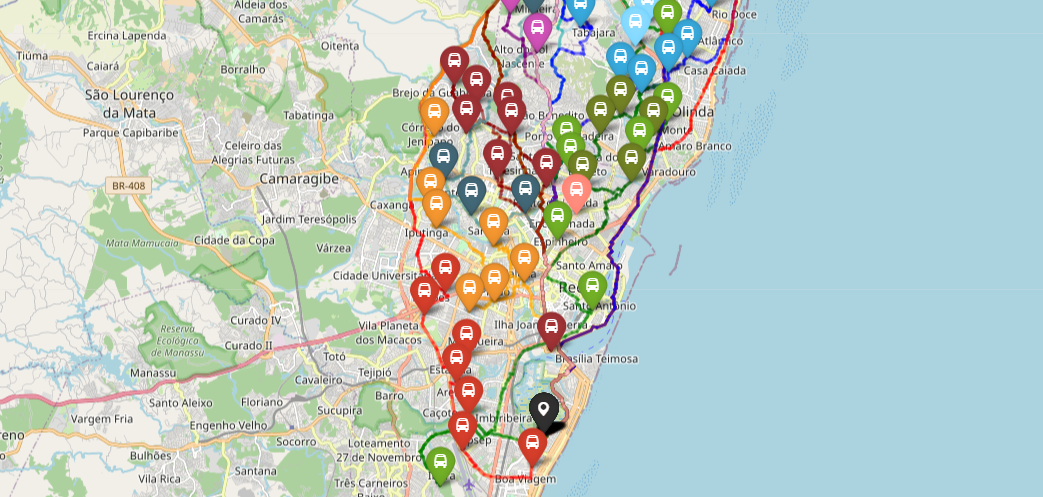